<a href="https://colab.research.google.com/github/Soumithp/GPU_tools/blob/main/esm2_embedding_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader

import torch
print(f"\nPyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Tesla T4, 15360 MiB

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4
VRAM: 15.6 GB


In [7]:
from google.colab import files
import os

print("=" * 60)
print("UPLOAD YOUR PROTEIN SEQUENCE FILE")
print("=" * 60)
print("\nSupported formats:")
print("  • FASTA (.fasta, .fa, .faa)")
print("  • Plain text (.txt) - one sequence per line or FASTA format")
print("  • Any extension - will auto-detect format")
print("\nClick 'Choose Files' button below...")
print("")

uploaded = files.upload()

# Get the uploaded filename
input_file = list(uploaded.keys())[0]
file_ext = os.path.splitext(input_file)[1].lower()

print(f"\n✓ File uploaded: {input_file}")
print(f"  Extension: {file_ext if file_ext else '(no extension)'}")
print(f"  Size: {os.path.getsize(input_file) / 1024:.1f} KB")

# Preview
print("\nFirst 15 lines:")
!head -n 15 {input_file}

UPLOAD YOUR PROTEIN SEQUENCE FILE

Supported formats:
  • FASTA (.fasta, .fa, .faa)
  • Plain text (.txt) - one sequence per line or FASTA format
  • Any extension - will auto-detect format

Click 'Choose Files' button below...



Saving proteins.fasta.txt to proteins.fasta (2).txt

✓ File uploaded: proteins.fasta (2).txt
  Extension: .txt
  Size: 1.3 KB

First 15 lines:
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `head -n 15 proteins.fasta (2).txt'


In [8]:
def detect_file_format(filepath):
    """
    Automatically detect if file is FASTA or plain text format

    Returns:
        'fasta' or 'plain'
    """
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line:  # First non-empty line
                if line.startswith('>'):
                    return 'fasta'
                else:
                    return 'plain'
    return 'plain'

def read_fasta_file(filepath):
    """
    Parse FASTA format file (handles multi-line sequences)

    Returns:
        List of (name, sequence) tuples
    """
    sequences = []
    current_name = None
    current_seq = []

    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()

            # Skip empty lines
            if not line:
                continue

            # Header line (starts with >)
            if line.startswith('>'):
                # Save previous sequence if exists
                if current_name is not None and current_seq:
                    # Join all sequence lines and remove spaces
                    full_sequence = ''.join(current_seq).replace(' ', '')
                    sequences.append((current_name, full_sequence))

                # Start new sequence
                # Extract ID (everything between first | and second |)
                if '|' in line:
                    parts = line[1:].split('|')
                    if len(parts) >= 3:
                        current_name = parts[2].split()[0]  # e.g., "HBA_HUMAN"
                    else:
                        current_name = parts[0].split()[0]
                else:
                    # No pipes, just take first word after >
                    current_name = line[1:].split()[0]

                current_seq = []
            else:
                # Sequence line - just append (don't remove spaces yet)
                current_seq.append(line)

        # Save last sequence
        if current_name is not None and current_seq:
            full_sequence = ''.join(current_seq).replace(' ', '')
            sequences.append((current_name, full_sequence))

    return sequences

def read_plain_text_file(filepath):
    """
    Parse plain text file (one sequence per line or paragraph)

    Handles formats:
    1. name:sequence or name\tsequence
    2. Just sequences (one per line)
    3. Multi-line sequences separated by blank lines

    Returns:
        List of (name, sequence) tuples
    """
    sequences = []

    with open(filepath, 'r') as f:
        content = f.read()

    # Split by double newlines (paragraphs)
    paragraphs = [p.strip() for p in content.split('\n\n') if p.strip()]

    if not paragraphs:
        # Single paragraph, split by single newlines
        lines = [line.strip() for line in content.split('\n') if line.strip()]
    else:
        lines = paragraphs

    for i, line in enumerate(lines):
        # Remove all whitespace from sequence part
        line = ' '.join(line.split())  # Normalize whitespace first

        # Check for name:sequence or name\tsequence format
        if ':' in line:
            parts = line.split(':', 1)
            name = parts[0].strip()
            sequence = parts[1].strip().replace(' ', '')
        elif '\t' in line:
            parts = line.split('\t', 1)
            name = parts[0].strip()
            sequence = parts[1].strip().replace(' ', '')
        else:
            # Just sequence, no name
            name = f"protein{i+1}"
            sequence = line.replace(' ', '')

        # Only add if non-empty
        if sequence:
            sequences.append((name, sequence))

    return sequences

def validate_protein_sequence(sequence):
    """
    Check if a sequence is a valid protein sequence

    Returns:
        (is_valid, cleaned_sequence, error_message)
    """
    # Valid amino acid one-letter codes
    valid_aa = set('ACDEFGHIKLMNPQRSTVWY')

    # Convert to uppercase
    sequence = sequence.upper()

    # Remove any remaining whitespace
    sequence = ''.join(sequence.split())

    # Check for invalid characters
    invalid_chars = set(sequence) - valid_aa

    if invalid_chars:
        return False, sequence, f"Invalid characters: {sorted(invalid_chars)}"

    if len(sequence) < 10:
        return False, sequence, f"Too short ({len(sequence)} aa, minimum 10)"

    if len(sequence) > 50000:
        return False, sequence, f"Too long ({len(sequence)} aa, maximum 50000)"

    return True, sequence, None

def smart_read_sequences(filepath):
    """
    Intelligently read protein sequences from any file format

    Args:
        filepath: Path to input file

    Returns:
        List of (name, sequence) tuples
    """
    print("=" * 60)
    print("SMART FILE PARSER")
    print("=" * 60)

    # Detect format
    file_format = detect_file_format(filepath)
    print(f"Detected format: {file_format.upper()}")
    print("")

    # Parse accordingly
    if file_format == 'fasta':
        print("Using FASTA parser...")
        sequences = read_fasta_file(filepath)
    else:
        print("Using plain text parser...")
        sequences = read_plain_text_file(filepath)

    print(f"Found {len(sequences)} sequences in file")
    print("")

    # Validate each sequence
    print("Validating sequences...")
    print("-" * 60)

    validated_sequences = []

    for name, seq in sequences:
        is_valid, cleaned_seq, error_msg = validate_protein_sequence(seq)

        if is_valid:
            validated_sequences.append((name, cleaned_seq))
            print(f"  ✓ {name}: {len(cleaned_seq)} aa")
        else:
            print(f"  ✗ {name}: {error_msg}")

    print("-" * 60)
    print(f"\n✓ Successfully validated {len(validated_sequences)} sequences")

    if len(validated_sequences) == 0:
        print("\n❌ ERROR: No valid protein sequences found!")
        print("\nTroubleshooting:")
        print("  • Check that sequences use standard amino acid codes")
        print("  • Ensure sequences are at least 10 amino acids long")
        print("  • Remove any special characters or numbers")
        raise ValueError("No valid sequences found in input file")

    return validated_sequences

# Use the smart parser
try:
    sequences = smart_read_sequences(input_file)

    # Display loaded sequences
    print("\n" + "=" * 60)
    print("LOADED SEQUENCES - DETAILS")
    print("=" * 60)
    for i, (name, seq) in enumerate(sequences, 1):
        print(f"\n{i}. {name}")
        print(f"   Length: {len(seq)} amino acids")
        print(f"   First 60 aa: {seq[:60]}")
        if len(seq) > 60:
            print(f"   Last 60 aa:  {seq[-60:]}")

    print("\n" + "=" * 60)
    print(f"✓ Ready to process {len(sequences)} proteins")
    print("=" * 60)

except Exception as e:
    print(f"\n❌ ERROR: {e}")
    print("\nPlease check your input file and try again.")
    raise

SMART FILE PARSER
Detected format: FASTA

Using FASTA parser...
Found 5 sequences in file

Validating sequences...
------------------------------------------------------------
  ✓ HBA_HUMAN: 142 aa
  ✓ HBB_HUMAN: 147 aa
  ✓ INS_HUMAN: 110 aa
  ✓ G3P_HUMAN: 333 aa
  ✓ LYSC_HUMAN: 147 aa
------------------------------------------------------------

✓ Successfully validated 5 sequences

LOADED SEQUENCES - DETAILS

1. HBA_HUMAN
   Length: 142 amino acids
   First 60 aa: MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHG
   Last 60 aa:  ALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR

2. HBB_HUMAN
   Length: 147 amino acids
   First 60 aa: MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPK
   Last 60 aa:  TLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH

3. INS_HUMAN
   Length: 110 amino acids
   First 60 aa: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAED
   Last 60 aa:  TPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN



In [9]:
# Install dependencies
!pip install fair-esm biopython -q

print("✓ Packages installed\n")

# Import
import esm
import numpy as np

# Load model
print("Loading ESM2-650M model...")
print("(First run downloads ~2.5 GB, takes 1-2 minutes)")
print("")

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print(f"✓ Model loaded on {device}")
print(f"  Parameters: 650 million")
print(f"  Layers: 33")
print(f"  Embedding dimension: 1280")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 75.1 MB/s eta 0:00:00
✓ Packages installed

Loading ESM2-650M model...
(First run downloads ~2.5 GB, takes 1-2 minutes)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
✓ Model loaded on cuda
  Parameters: 650 million
  Layers: 33
  Embedding dimension: 1280


In [10]:
print("\n" + "=" * 60)
print("GENERATING EMBEDDINGS")
print("=" * 60)
print(f"Processing {len(sequences)} proteins on GPU...")
print("")

# Prepare batch
batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)
batch_tokens = batch_tokens.to(device)

# Generate embeddings
import time
start_time = time.time()

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=False)

embeddings = results["representations"][33].cpu().numpy()
elapsed = time.time() - start_time

print(f"✓ Embeddings generated in {elapsed:.1f} seconds!")
print(f"\nOutput shape: {embeddings.shape}")
print(f"  - {embeddings.shape[0]} proteins")
print(f"  - Max {embeddings.shape[1]} positions per protein")
print(f"  - {embeddings.shape[2]} dimensions per position")
print(f"\nTotal embedding values: {embeddings.size:,}")


GENERATING EMBEDDINGS
Processing 5 proteins on GPU...

✓ Embeddings generated in 2.2 seconds!

Output shape: (5, 335, 1280)
  - 5 proteins
  - Max 335 positions per protein
  - 1280 dimensions per position

Total embedding values: 2,144,000


In [12]:
import os

print("\n" + "=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Create results directory
os.makedirs("results", exist_ok=True)

# Save input file
# Fix: Enclose input_file and output path in quotes to handle filenames with special characters (like parentheses)
!cp "{input_file}" "results/input_sequences{file_ext}"

# Save embeddings
for i, (name, seq) in enumerate(sequences):
    # Clean filename (remove special characters)
    clean_name = name.replace("|", "_").replace("/", "_").replace(":", "_")

    # Save embedding
    np.save(f"results/{clean_name}_embedding.npy", embeddings[i])

    # Save metadata
    with open(f"results/{clean_name}_info.txt", "w") as f:
        f.write(f"Protein: {name}\n")
        f.write(f"Sequence length: {len(seq)} amino acids\n")
        f.write(f"\nSequence:\n")
        # Write sequence in 60-character lines (FASTA standard)
        for j in range(0, len(seq), 60):
            f.write(seq[j:j+60] + "\n")
        f.write(f"\nEmbedding information:\n")
        f.write(f"  Shape: {embeddings[i].shape}\n")
        # Fix: Access correct shape indices. embeddings[i].shape is (positions, features).
        # So, positions is at index 0 and features is at index 1.
        f.write(f"  Dimensions: {embeddings[i].shape[0]} positions × {embeddings[i].shape[1]} features\n")
        f.write(f"\nStatistics:\n")
        f.write(f"  Mean: {embeddings[i].mean():.6f}\n")
        f.write(f"  Std:  {embeddings[i].std():.6f}\n")
        f.write(f"  Min:  {embeddings[i].min():.6f}\n")
        f.write(f"  Max:  {embeddings[i].max():.6f}\n")

    print(f"  ✓ {name}")

print(f"\n✓ All results saved to results/")
print("\nDirectory contents:")
!ls -lh results/ | head -n 20


SAVING RESULTS
  ✓ HBA_HUMAN
  ✓ HBB_HUMAN
  ✓ INS_HUMAN
  ✓ G3P_HUMAN
  ✓ LYSC_HUMAN

✓ All results saved to results/

Directory contents:
total 8.3M
-rw-r--r-- 1 root root 1.7M Feb 24 17:59 G3P_HUMAN_embedding.npy
-rw-r--r-- 1 root root  575 Feb 24 17:59 G3P_HUMAN_info.txt
-rw-r--r-- 1 root root 1.7M Feb 24 17:59 HBA_HUMAN_embedding.npy
-rw-r--r-- 1 root root  381 Feb 24 17:59 HBA_HUMAN_info.txt
-rw-r--r-- 1 root root 1.7M Feb 24 17:59 HBB_HUMAN_embedding.npy
-rw-r--r-- 1 root root  386 Feb 24 17:59 HBB_HUMAN_info.txt
-rw-r--r-- 1 root root 1.3K Feb 24 17:59 input_sequences.txt
-rw-r--r-- 1 root root 1.7M Feb 24 17:59 INS_HUMAN_embedding.npy
-rw-r--r-- 1 root root  348 Feb 24 17:59 INS_HUMAN_info.txt
-rw-r--r-- 1 root root 1.7M Feb 24 17:59 LYSC_HUMAN_embedding.npy
-rw-r--r-- 1 root root  387 Feb 24 17:59 LYSC_HUMAN_info.txt


PROTEIN SIMILARITY ANALYSIS

Pairwise cosine similarities:
------------------------------------------------------------
  HBA_HUMAN                 ↔ HBB_HUMAN                : 0.9789
  HBA_HUMAN                 ↔ INS_HUMAN                : 0.8889
  HBA_HUMAN                 ↔ G3P_HUMAN                : 0.9151
  HBA_HUMAN                 ↔ LYSC_HUMAN               : 0.9507
  HBB_HUMAN                 ↔ INS_HUMAN                : 0.9056
  HBB_HUMAN                 ↔ G3P_HUMAN                : 0.9415
  HBB_HUMAN                 ↔ LYSC_HUMAN               : 0.9659
  INS_HUMAN                 ↔ G3P_HUMAN                : 0.8622
  INS_HUMAN                 ↔ LYSC_HUMAN               : 0.9258
  G3P_HUMAN                 ↔ LYSC_HUMAN               : 0.9293

CREATING VISUALIZATIONS


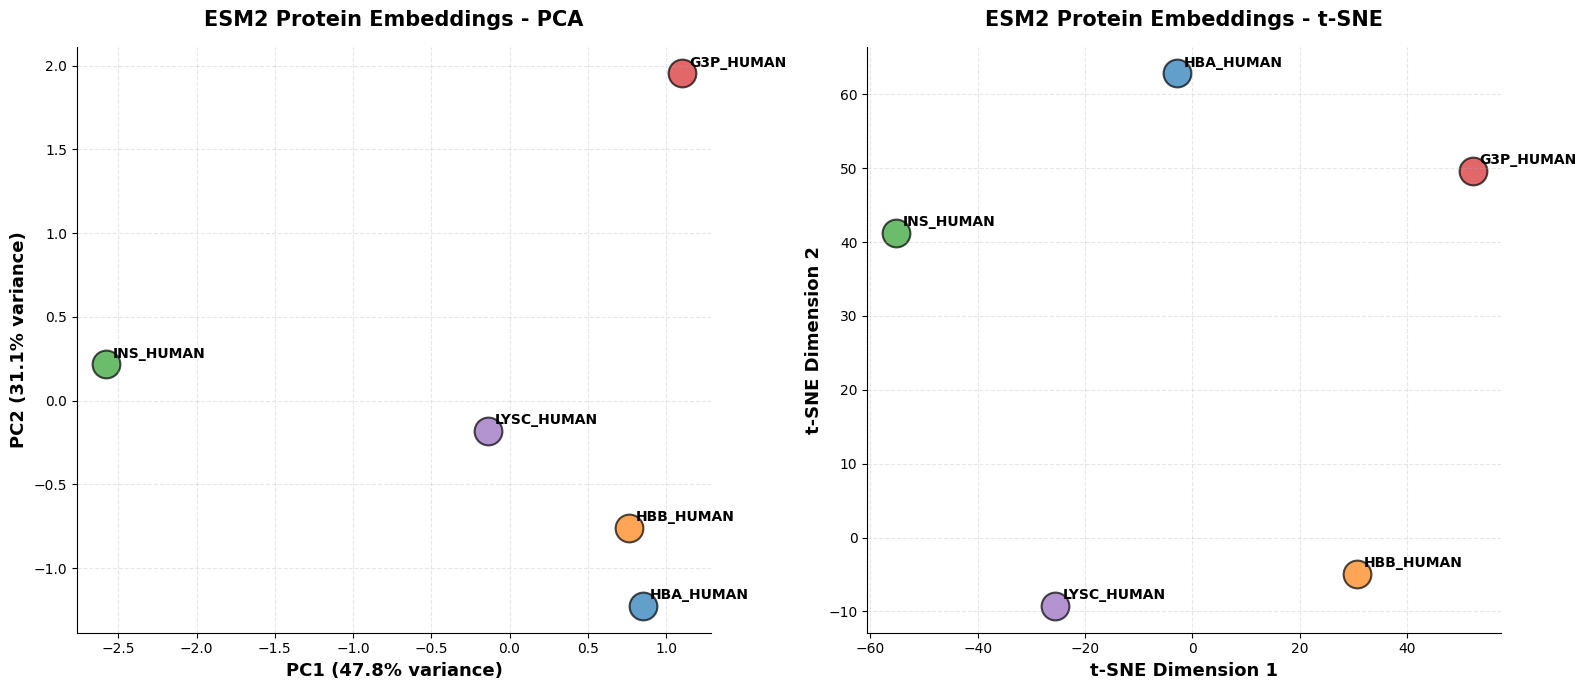


✓ Visualization saved


In [13]:
if len(sequences) < 2:
    print("Need at least 2 proteins for similarity visualization")
    print("Skipping visualization...")
else:
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from scipy.spatial.distance import cosine

    print("=" * 60)
    print("PROTEIN SIMILARITY ANALYSIS")
    print("=" * 60)

    # Average across positions
    avg_embeddings = embeddings.mean(axis=1)

    # Compute pairwise similarities
    print("\nPairwise cosine similarities:")
    print("-" * 60)
    for i in range(len(sequences)):
        for j in range(i + 1, len(sequences)):
            name1 = sequences[i][0]
            name2 = sequences[j][0]
            similarity = 1 - cosine(avg_embeddings[i], avg_embeddings[j])
            print(f"  {name1[:25]:25s} ↔ {name2[:25]:25s}: {similarity:.4f}")

    # Create visualization
    print("\n" + "=" * 60)
    print("CREATING VISUALIZATIONS")
    print("=" * 60)

    # Determine layout
    if len(sequences) >= 3:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 7))
        ax2 = None

    # --- PCA Plot ---
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(avg_embeddings)

    colors = plt.cm.tab10(range(len(sequences)))
    for i, (name, _) in enumerate(sequences):
        display_name = name[:20]  # Truncate long names
        ax1.scatter(emb_pca[i, 0], emb_pca[i, 1], s=400, alpha=0.7,
                   color=colors[i], edgecolor='black', linewidth=1.5)
        ax1.annotate(display_name, (emb_pca[i, 0], emb_pca[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold')

    ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)",
                  fontsize=13, fontweight='bold')
    ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)",
                  fontsize=13, fontweight='bold')
    ax1.set_title("ESM2 Protein Embeddings - PCA",
                 fontsize=15, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # --- t-SNE Plot (if 3+ proteins) ---
    if ax2 is not None and len(sequences) >= 3:
        perplexity = min(len(sequences) - 1, 5)
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        emb_tsne = tsne.fit_transform(avg_embeddings)

        for i, (name, _) in enumerate(sequences):
            display_name = name[:20]
            ax2.scatter(emb_tsne[i, 0], emb_tsne[i, 1], s=400, alpha=0.7,
                       color=colors[i], edgecolor='black', linewidth=1.5)
            ax2.annotate(display_name, (emb_tsne[i, 0], emb_tsne[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=10, fontweight='bold')

        ax2.set_xlabel("t-SNE Dimension 1", fontsize=13, fontweight='bold')
        ax2.set_ylabel("t-SNE Dimension 2", fontsize=13, fontweight='bold')
        ax2.set_title("ESM2 Protein Embeddings - t-SNE",
                     fontsize=15, fontweight='bold', pad=15)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig("results/protein_embeddings_visualization.png",
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Visualization saved")

In [14]:
with open("results/analysis_summary.txt", "w") as f:
    f.write("=" * 70 + "\n")
    f.write("ESM2 PROTEIN EMBEDDING ANALYSIS - SUMMARY\n")
    f.write("=" * 70 + "\n\n")

    f.write(f"Input file: {input_file}\n")
    f.write(f"File format: {detect_file_format(input_file).upper()}\n")
    f.write(f"Number of proteins: {len(sequences)}\n")
    f.write(f"Model: ESM2-650M (33 layers, 1280-dimensional embeddings)\n")
    f.write(f"Processing device: {device}\n\n")

    f.write("PROTEINS ANALYZED:\n")
    f.write("-" * 70 + "\n")
    for i, (name, seq) in enumerate(sequences, 1):
        f.write(f"{i}. {name}\n")
        f.write(f"   Length: {len(seq)} amino acids\n")
        f.write(f"   First 60 aa: {seq[:60]}\n")
        f.write(f"\n")

    if len(sequences) >= 2:
        f.write("=" * 70 + "\n")
        f.write("PAIRWISE SIMILARITIES (Cosine)\n")
        f.write("=" * 70 + "\n")
        avg_embeddings = embeddings.mean(axis=1)
        for i in range(len(sequences)):
            for j in range(i + 1, len(sequences)):
                name1 = sequences[i][0]
                name2 = sequences[j][0]
                similarity = 1 - cosine(avg_embeddings[i], avg_embeddings[j])
                f.write(f"{name1[:30]:30s} ↔ {name2[:30]:30s}: {similarity:.4f}\n")

    f.write("\n" + "=" * 70 + "\n")
    f.write("OUTPUT FILES:\n")
    f.write("=" * 70 + "\n")
    f.write("For each protein:\n")
    f.write("  • {name}_embedding.npy - NumPy array of embeddings\n")
    f.write("  • {name}_info.txt - Sequence and statistics\n")
    f.write("\nVisualization:\n")
    f.write("  • protein_embeddings_visualization.png\n")
    f.write("\nSummary:\n")
    f.write("  • analysis_summary.txt (this file)\n")

print("✓ Summary report created")
print("\nReport preview:")
!head -n 40 results/analysis_summary.txt

✓ Summary report created

Report preview:
ESM2 PROTEIN EMBEDDING ANALYSIS - SUMMARY

Input file: proteins.fasta (2).txt
File format: FASTA
Number of proteins: 5
Model: ESM2-650M (33 layers, 1280-dimensional embeddings)
Processing device: cuda

PROTEINS ANALYZED:
----------------------------------------------------------------------
1. HBA_HUMAN
   Length: 142 amino acids
   First 60 aa: MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHG

2. HBB_HUMAN
   Length: 147 amino acids
   First 60 aa: MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPK

3. INS_HUMAN
   Length: 110 amino acids
   First 60 aa: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAED

4. G3P_HUMAN
   Length: 333 amino acids
   First 60 aa: MVKVGVNGFGRIGRLVTRAAFNSGKVDIVAINDPFIDLNYMVYMFQYDSTHGKFHGTVKA

5. LYSC_HUMAN
   Length: 147 amino acids
   First 60 aa: MRSLLILVLCFLPLAALGKVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQA

PAIRWISE SIMILARITIES (Cosine)
HBA_HUMAN                      ↔ HBB_HUMAN  

In [17]:
# Package everything
!zip -r -q esm2_results.zip results/

print("=" * 60)
print("DOWNLOAD READY")
print("=" * 60)
print(f"\nInput format: {detect_file_format(input_file).upper()}")
print(f"Proteins processed: {len(sequences)}")
print("\nPackage size:")
!ls -lh esm2_results.zip

print("\nDownloading...")
from google.colab import files
files.download('esm2_results.zip')

print("\n✓ Download complete!")
print("\n📁 Next steps:")
print("  1. Unzip esm2_results.zip on your Mac")
print("  2. Move to: stowers-gpu-tools/esm2/results/sample_output/")
print("  3. Commit to Git")

DOWNLOAD READY

Input format: FASTA
Proteins processed: 5

Package size:
-rw-r--r-- 1 root root 7.9M Feb 24 18:03 esm2_results.zip

Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Download complete!

📁 Next steps:
  1. Unzip esm2_results.zip on your Mac
  2. Move to: stowers-gpu-tools/esm2/results/sample_output/
  3. Commit to Git
